

# Amazon fine food review - Sentiment analysis
 

## Data preparation

Let's load some library needed throughout the analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Now we load in the dataset and add some columns for upvote metrics:

In [3]:
odf = pd.read_csv('/content/drive/MyDrive/Datasets/Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1.0, 'How helpful users find among user scores')

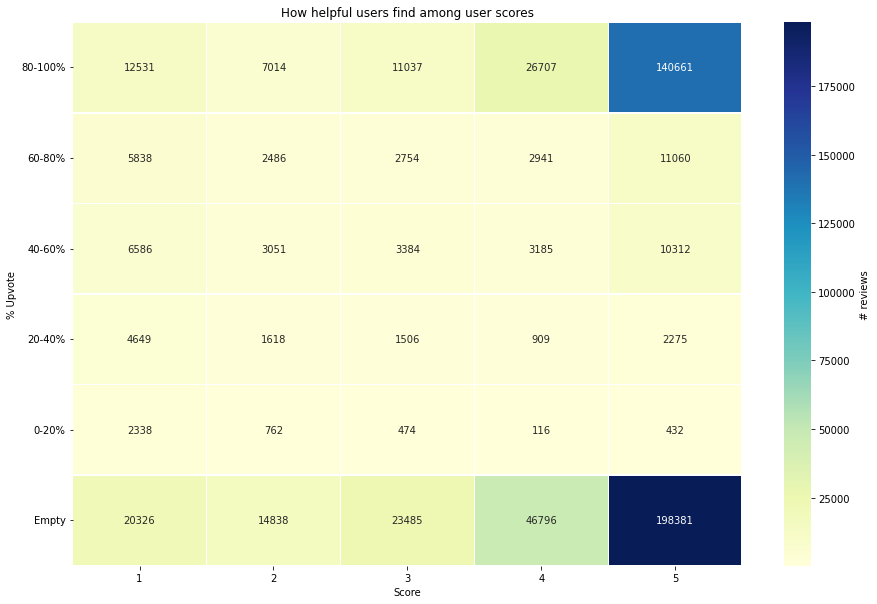

In [4]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:
* Reviews are skewed towards positive
* More than half of the reviews are with zero votes
* Many people agree with score 5 reviews

Then we get rid of score 3 reviews (neutral), and separate the remaining reviews into binary class (1 = positive, 0 = negative):

In [5]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

## Score prediction
### Logistic regression model on word count

In [6]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model Accuracy: 0.9358102454090405

-Top 20 positive-
       Word  Coefficient
 pleasantly     4.232730
   downside     3.125648
  addicting     2.958208
   drawback     2.669476
  skeptical     2.510482
     resist     2.379250
 economical     2.265155
       whim     2.235738
   soothing     2.218361
    easiest     2.206106
     hooked     2.173942
    welcome     2.083908
  delighted     2.078764
      meets     1.976063
        yay     1.975571
  excellent     1.970803
wonderfully     1.970568
    worries     1.944912
exceptional     1.941874
     delish     1.933417

-Top 20 negative-
         Word  Coefficient
        ruins    -2.305289
       lacked    -2.326984
        blech    -2.333991
   unfinished    -2.349367
   unbearable    -2.355606
          ick    -2.418676
   overpowers    -2.488406
  unappealing    -2.531167
  disapointed    -2.557415
      defeats    -2.613754
   returnable    -2.683771
     mediocre    -2.735403
       ripoff    -2.843023
disappointing    -2.9458

Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg.

Let's also look at the base line accuracy (predicting with majority class, in this case positive class):

In [7]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.8437324082949168


### Logistic regression model on TFIDF

In [8]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())


# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model Accuracy: 0.9346083040455216

-Top 20 positive-
      Word  Coefficient
     great    13.695298
 delicious    12.264886
      best    11.967094
   perfect    10.723732
 excellent    10.013792
     loves     9.552907
    highly     8.970362
      love     8.286137
 wonderful     8.087789
   amazing     7.729151
   awesome     7.501135
pleasantly     7.455942
      good     7.348545
      nice     7.096568
    hooked     7.076224
   pleased     6.980317
    smooth     6.910817
  favorite     6.853610
     yummy     6.821671
 fantastic     6.569467

-Top 20 negative-
          Word  Coefficient
         waste    -5.647138
          poor    -5.756170
   undrinkable    -5.866625
          yuck    -5.945607
         stale    -6.088770
         worse    -6.217101
         bland    -6.345562
          weak    -6.477051
    disgusting    -6.514147
         threw    -6.727794
     tasteless    -6.733551
        return    -6.795280
 unfortunately    -7.411392
      horrible    -7.850534
dis

Accurancy is roughly the same - 93.5%. However we notice that the significant words make much more sense now, with higher coefficient magnitude as well!

### Logistic regression model on TFIDF + ngram

In [9]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model Accuracy: 0.9456768147032422

-Top 20 positive-
     Word  Coefficient
    great    20.656004
     best    17.912018
delicious    16.972224
  perfect    14.507385
    loves    13.706369
     love    13.044294
excellent    13.036191
     good    11.403729
wonderful    11.200842
     nice    10.901578
 favorite    10.659798
  amazing     9.561725
  awesome     9.251510
     easy     9.141534
    happy     8.964936
  pleased     8.778300
   smooth     8.607139
    yummy     8.502293
    tasty     8.459028
   highly     8.402930

-Top 20 negative-
          Word  Coefficient
         maybe    -7.892097
        hoping    -8.053516
         money    -8.167249
     tasteless    -8.196235
         worse    -8.266857
       thought    -8.448484
    disgusting    -8.679442
         bland    -9.116741
         threw    -9.248305
         stale    -9.972202
        return   -10.099827
          weak   -10.110367
disappointment   -10.274333
 unfortunately   -10.802058
      horrible   -11.287

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see "highly recommend" is on 20th place of positive words

## Upvote prediction
### Data preview

This study is to see whether there is pattern found for unpopular (downvote) comments by users (might be used to boost sales).
We will be focusing on score 5 reviews, and get rid of comments with neutral votes:

In [10]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1.0    151721
0.0      2707
Name: % Upvote, dtype: int64


The target class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:

In [11]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


### Logistic regression model on word count

In [12]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 16137
# train records: 4060
# test records: 1354
Model Accuracy: 0.7149187592319055

-Top 20 positive-
       Word  Coefficient
     keurig     1.443733
      value     1.433375
   quantity     1.341859
     heaven     1.211095
        ton     1.207693
        run     1.189732
     nearly     1.178797
outstanding     1.146865
   fabulous     1.132027
      chewy     1.100735
  microwave     1.097077
   cinnamon     1.089618
    veggies     1.080102
   standard     1.068303
   training     1.058342
      puppy     1.032235
   cherries     1.031435
     needed     1.021318
        vet     0.999389
        fix     0.997645

-Top 20 negative-
      Word  Coefficient
      yoga    -0.966400
    unique    -1.016920
   camping    -1.018013
    manner    -1.025535
   freshly    -1.037944
      pour    -1.046886
    joints    -1.051037
     purse    -1.052286
     fills    -1.062360
     beats    -1.069643
   feeling    -1.071956
     kashi    -1.153103
cappuccino    -1.173077
  bro

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The words look no sense at all, and the coefficients are very small.

### Logistic regression model on TFIDF + ngram

In [13]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 144846
# train records: 4060
# test records: 1354
Model Accuracy: 0.7333825701624815


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



-Top 20 positive-
    Word  Coefficient
    food     1.991664
      ve     1.510460
     bag     1.487181
     mix     1.450314
    make     1.424865
    salt     1.422660
 perfect     1.261858
     lot     1.256071
   chips     1.243114
favorite     1.184554
   fresh     1.172004
    teas     1.063432
 chicken     1.032539
  brands     1.024751
  weight     1.008643
   small     0.966532
  flavor     0.963645
   pasta     0.942644
   jerky     0.941255
     dog     0.939848

-Top 20 negative-
        Word  Coefficient
      bottle    -0.841229
      people    -0.847947
      seller    -0.854304
        sure    -0.855970
        wish    -0.884972
        yoga    -0.914711
       order    -1.032738
        know    -1.061646
       money    -1.072166
     product    -1.076605
      lipton    -1.080713
        zico    -1.081512
  cappuccino    -1.089607
      marley    -1.102238
great coffee    -1.107829
     service    -1.175180
       water    -1.254389
      coffee    -1.407499
      

Similar to count metric, the accuracy isn't very high and words are not meaningful.

### Study on non-context features

Study on non-context featuresLet's look at some examples of upvote and downvote comments:

In [14]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
205221    We live in a climate that produces mouth-water...
203847    We have purchased many gluten free products fo...
456277    The box was full of fun surprises !!! More tha...
525642    As a single person, I find the portions of ang...
226261    This stuff is wonderful.  I like carbonated dr...
Name: Text, dtype: object


Time to extract some possible features:

In [15]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']


% Upvote                  0          1
word_count        83.927226  88.064278
capital_count     19.252678  14.037311
question_mark      0.180273   0.076838
exclamation_mark   0.906169   0.879941
punctuation       22.482822  19.551533


Now we train the model to predict:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5878877400295421
SVM accuracy: 0.5812407680945347


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.

## In-depth study on user behaviour

This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, based on the reviews he / she had given in the past. This can be expanded to all users later on. 

First let's look at how many reviews each user gave in the past:

In [17]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))


                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:

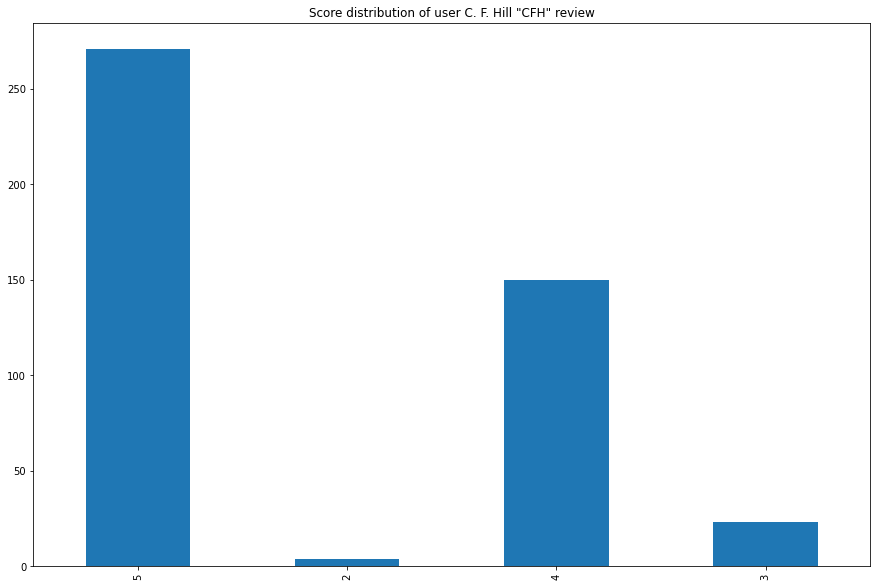

In [18]:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's dig into that:

In [19]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Bennett seems a good target:

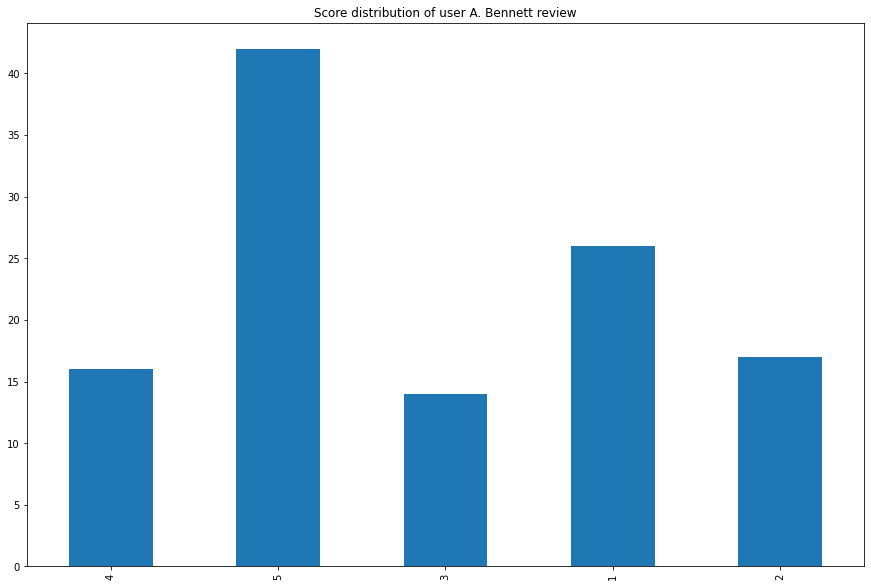

In [20]:
plot_user('A2M9D9BDHONV3Y')

He seems like a better analysis target! Now let's dig deep into his reviews:

In [21]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)



score 1 reviews most popular 2-gram / 3-gram:
                    Phrase  Count  Occur %
0               (..., ...)   31.0  119.23%
1          (..., ..., ...)   17.0   65.38%
2             (never, buy)   11.0   42.31%
3           (buy, product)    9.0   34.62%
4    (never, buy, product)    8.0   30.77%
5  (monosodium, glutamate)    8.0   30.77%
6         (dry, tasteless)    7.0   26.92%
7          (picture, look)    7.0   26.92%
8            (decide, try)    7.0   26.92%
score 2 reviews most popular 2-gram / 3-gram:
                  Phrase  Count Occur %
0          (ruin, whole)    8.0  47.06%
1   (sauce, ruin, whole)    8.0  47.06%
2          (sauce, ruin)    8.0  47.06%
3        (product, ever)    6.0  35.29%
4             (n't, buy)    6.0  35.29%
5            (try, like)    5.0  29.41%
6      (n't, get, wrong)    5.0  29.41%
7      (buy, particular)    5.0  29.41%
8           (get, wrong)    5.0  29.41%
9             (n't, get)    5.0  29.41%
10     (..., .give, try)    5.0  29.41

Seems like A. Bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). He likes using the phrase "..." a lot as well. Sample size is very small though.

Let's look at full picture now instead of just one user:

In [22]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
           Phrase   Count Occur %
0   (taste, like)  5536.0  10.59%
1  (waste, money)  2316.0   4.43%
2    (could, n't)  2175.0   4.16%
3     (n't, even)  2111.0   4.04%
4     (n't, know)  1809.0   3.46%
5    (would, n't)  1794.0   3.43%
6      (n't, buy)  1644.0   3.15%
score 2 reviews most popular 2-gram / 3-gram:
           Phrase   Count Occur %
0   (taste, like)  3161.0  10.62%
1     (n't, like)  1362.0   4.58%
2    (would, n't)  1304.0   4.38%
3  (think, would)  1086.0   3.65%
4      (n't, buy)  1064.0   3.57%
5     (n't, know)  1010.0   3.39%
6    (n't, taste)   996.0   3.35%
7    (could, n't)   945.0   3.17%
8   (taste, good)   910.0   3.06%
score 3 reviews most popular 2-gram / 3-gram:
           Phrase   Count Occur %
0   (taste, like)  3237.0   7.59%
1    (would, n't)  1632.0   3.83%
2     (n't, like)  1612.0   3.78%
3   (taste, good)  1551.0   3.64%
4   (href=, http)  1463.0   3.43%
5     (n't, know)  1406.0    3.3%
6  (think, w

Funny that people are more likely to attach HTML links (href=) for more positive reviews (3 and 4).
<br>
Other than that, not much useful discoveries except positive / negative tones, since people are very different in texting style. 
<br>
Maybe we should focus on popular single **adjective** word people used for different score. First we modify the function a bit for easier implementation:

In [23]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

Let's look at user A. Bennett again:

In [24]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Phrase  Count Occur %
0        dry   13.0   50.0%
1     cheese   12.0  46.15%
2        bad   10.0  38.46%
3     little   10.0  38.46%
4       hard    8.0  30.77%
5  delicious    8.0  30.77%
6      tasty    8.0  30.77%
7  expensive    8.0  30.77%
8      bread    7.0  26.92%
9       poor    7.0  26.92%
score 2 reviews most popular adjectives word:
       Phrase  Count Occur %
0       whole   10.0  58.82%
1      cheese    8.0  47.06%
2       awful    6.0  35.29%
3       wrong    6.0  35.29%
4   delicious    6.0  35.29%
5       .give    5.0  29.41%
6  particular    5.0  29.41%
7        good    5.0  29.41%
score 3 reviews most popular adjectives word:
         Phrase  Count Occur %
0         whole    9.0  64.29%
1          high    5.0  35.71%
2  disappointed    4.0  28.57%
3         great    4.0  28.57%
4          good    4.0  28.57%
5         first    4.0  28.57%
score 4 reviews most popular adjectives word:
      Phrase  Count Occur %
0 

Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
<br>
Let's also look at big picture:

In [25]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
          Phrase    Count Occur %
0           good  16185.0  30.97%
1            bad  10777.0  20.62%
2          great   4977.0   9.52%
3           much   4844.0   9.27%
4         little   4786.0   9.16%
5            old   4774.0   9.13%
6          first   4198.0   8.03%
7            new   3956.0   7.57%
8      different   3789.0   7.25%
9           many   3717.0   7.11%
10         small   3537.0   6.77%
11          real   3296.0   6.31%
12  disappointed   3000.0   5.74%
13          sure   2884.0   5.52%
14          free   2831.0   5.42%
15          diet   2823.0    5.4%
16          high   2761.0   5.28%
17          last   2658.0   5.09%
score 2 reviews most popular adjectives word:
          Phrase    Count Occur %
0           good  13519.0  45.41%
1           much   4251.0  14.28%
2            bad   4169.0   14.0%
3          great   3909.0  13.13%
4         little   3691.0   12.4%
5          small   2847.0   9.56%
6          first   2323.